# Training ANNs to learn the Van Der Pol equation

Lets create and run a system per the 1993 paper "Identification of Continuous-Time Dynamical Systems: Neural Network Based Algorithms and Parallel Implementation" which can be found at https://arxiv.org/abs/comp-gas/9305001

Lets see what Python shows for the Van Der Pol equation. 

In [95]:
#Settings used in https://arxiv.org/pdf/comp-gas/9305001.pdf
mu = 1.
delta = 4.0
omega = 1.0

#Settings used in https://arxiv.org/pdf/comp-gas/9305001.pdf
#nSamples=500
nSamples=10000

#mu = 0.2
#delta = 1.0
#omega = 1.0


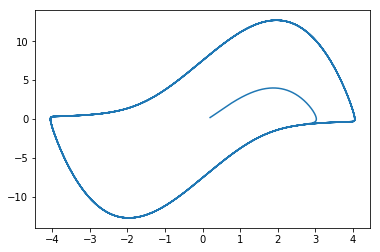

In [96]:
# %load viewPredict.py
import numpy as np
from pylab import *
from scipy.integrate import odeint

def van_der_pol_oscillator_deriv(x, t):
    nx0 = x[1]
    nx1 = -mu * (x[0] ** 2.0 - delta) * x[1] - omega * x[0]
    res = np.array([nx0, nx1])
    return res

ts = np.linspace(0.0, 50.0, nSamples)

xs = odeint(van_der_pol_oscillator_deriv, [0.2, 0.2], ts)
plt.plot(xs[:,0], xs[:,1])

plt.show() 


We want to train using a 4th order Runga-Kutta integrator like the following which generates the file train.dat. Note we change the Van Der Pol paramters to be those in the paper.

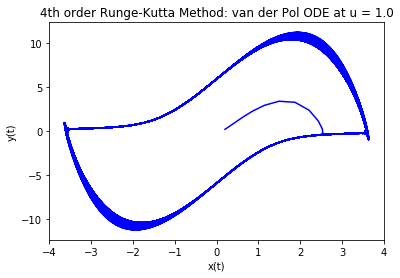

In [97]:
# RK2D.py: Plot out time series of integration steps of a 2D ODE
#      to illustrate the fourth-order Runge-Kutta method.
#
# For a 2D ODE
#     dx/dt = f(x,y)
#     dy/dt = g(x,y)
# See RKTwoD() below for how the fourth-order Rungle-Kutta method integrates.
#

# Import plotting routines
from pylab import *
import numpy as np
import struct

# The van der Pol 2D ODE
def van_der_pol_oscillator_deriv(x, t):
    nx0 = x[1]
    nx1 = -mu * (x[0] ** 2.0 - delta) * x[1] - omega * x[0]
    res = np.array([nx0, nx1])
    return res

# 2D Fourth-Order Runge-Kutta Integrator
def RKTwoD(x, f, t):
    x = np.array(x)
    k1 = dt * f(x,t)
    k2 = dt * f(x + x / 2.0,t)
    k3 = dt * f(x + k2 / 2.0,t)
    k4 = dt * f(x + k3,t)
    x = x + ( k1 + 2.0 * k2 + 2.0 * k3 + k4 ) / 6.0
    return x

# Simulation parameters
# Integration time step
dt = 0.1

# Time
t  = [ 0.0]

# The main loop that generates the orbit, storing the states
xs= np.empty((nSamples+1,2))
xs[0]=[0.2,0.2]

for i in range(0,nSamples):
  # at each time step calculate new x(t) and y(t)
  xs[i+1]=(RKTwoD(xs[i],van_der_pol_oscillator_deriv,dt))
  t.append(t[i] + dt)
    
#convert this to binary
fn = open('train.dat','wb')
fn.write(bytearray(struct.pack('i',int(2))))
fn.write(bytearray(struct.pack('i',int(2))))
fn.write(bytearray(struct.pack('i',int(nSamples))))

for i in range(0,nSamples):
    # write input
    fn.write(bytearray(struct.pack('f',xs[i][0]))) 
    fn.write(bytearray(struct.pack('f',xs[i][1]))) 
    #write output
    fn.write(bytearray(struct.pack('f',xs[i+1][0]))) 
    fn.write(bytearray(struct.pack('f',xs[i+1][1]))) 
fn.close()

#for i in range(0,nSamples):
 #   print(xs[i],xs[i+1])


# Setup the parametric plot
xlabel('x(t)') # set x-axis label
ylabel('y(t)') # set y-axis label
title('4th order Runge-Kutta Method: van der Pol ODE at u = ' + str(mu)) # set plot title
#axis('equal')

# Plot the trajectory in the phase plane
plot(xs[:,0],xs[:,1],'b')
show()

We train the neural network with the following. The maximum runtime is 60 seconds, but it only takes around 40 seconds to run to completion.
The file param.dat is deleted below so we start from random initial conditions.

The following shows the basic configuration for this network

In [98]:
f=open("FcnOfInterest_config.h","w")
f.write("#define GFCN Tanh_G\n")
f.write('#define RK4_H 0.1\n')
f.write('#define PREDFCN rhs\n')
f.write('#define EXPLICIT_RK4\n')
f.close()

In [99]:
import subprocess
output = subprocess.getoutput(['make -j'])
output = subprocess.getoutput(['sh BUILD.python.module.sh'])

output = subprocess.getoutput(['rm -f param.dat'])
output = subprocess.getoutput(['./nloptTrain.x -p param.dat -d train.dat -t 60'])
print(output)

training data in: train.dat
using and/or writing params to: param.dat
OMP_NUM_THREADS 24
nInput 2 nOutput 2 nExamples 10000 in datafile (train.dat)
*******************
Objective Function: Least Means Squared
Function of Interest: EXPLICIT RK4 twolayer 2x5x5x2
Citation: https://arxiv.org/pdf/comp-gas/9305001.pdf
RK4_H=0.100000 with G() tanh()
Number params 57
Max Runtime is 60 seconds
Using NLOPT_LD_LBFGS
	Optimization Time 1.67678
	nlopt failed! ret -1
RUNTIME Info (10000 examples)
	DataLoadtime 0.00427707 seconds
	AveObjTime 0.000602461, countObjFunc 130, totalObjTime 0.0777175
	Estimated Flops myFunc 217,average GFlop/s 3.60189 nFuncCalls 130
	Estimated maximum GFlop/s 4.28776, minimum GFLop/s 1.58078
	AveGradTime 0.0122418, nGradCalls 130, totalGradTime 1.59143
	nFuncCalls/nGradCalls 1.00


This shows we trained with the EXPLICIT RK4 implementation described in the paper. Let's look at the output by calling the C++ prediction function using the model parameters from the training run. We can then integrate to see if we learned the Van Der Pol equation.

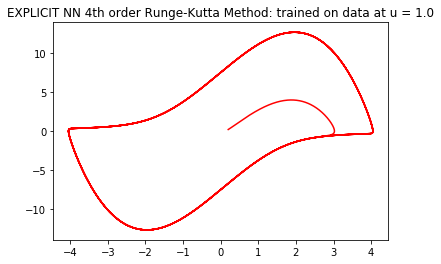

In [100]:
# Import plotting routines
from pylab import *
import numpy as np
import struct
from farbopt import PyPredFcn

from scipy.integrate import odeint

def van_der_pol_oscillator_deriv(x, t):
    nx0 = x[1]
    nx1 = -mu * (x[0] ** 2.0 - delta) * x[1] - omega * x[0]
    res = np.array([nx0, nx1])
    return res

ts = np.linspace(0.0, 50.0, nSamples)

xs = odeint(van_der_pol_oscillator_deriv, [0.2, 0.2], ts)

title('EXPLICIT NN 4th order Runge-Kutta Method: trained on data at u = ' + str(mu)) # set plot title

plt.plot(xs[:,0], xs[:,1],'r')
#plt.gca().set_aspect('equal')
#plt.savefig('vanderpol_oscillator.png')
plt.show() 

# Implicit implementation

Looks good! Now lets try the implicit integrator using ANN recursion. See paper for more details

In [101]:
# Simulation parameters
# Integration time step
# The number of time steps to integrate over
#nSamples = 10000
dt_step = 0.02
nRecurIters=int(dt/dt_step) # we iterate to the previous dt
writeImplicitData=1 # keep the previous data set

def ImplicitMethod(x,f,t):
    x = np.array(x)
    Yn_1 = np.array(f(x,t))
    t1 = np.array(f(x,t))
    for i in range(nRecurIters):
        Yn_1 = x + dt_step/2. * (t1 + np.array(f(Yn_1,t)))
    return Yn_1

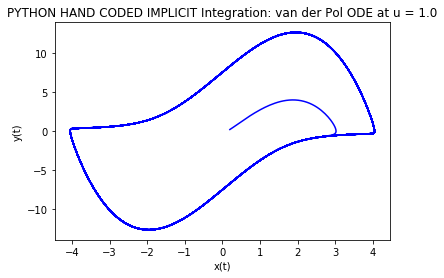

In [102]:
#Implicit integrator

# Import plotting routines
from pylab import *
import numpy as np
import struct

# The van der Pol 2D ODE
def van_der_pol_oscillator_deriv(x, t):
    nx0 = x[1]
    nx1 = -mu * (x[0] ** 2.0 - delta) * x[1] - omega * x[0]
    res = np.array([nx0, nx1])
    return res


# Time
t  = [ 0.0]

# The main loop that generates the orbit, storing the states
xs= np.empty((nSamples+1,2))
xs[0]=[0.2,0.2]

for i in range(0,nSamples):
  # at each time step calculate new x(t) and y(t)
  xs[i+1]=(ImplicitMethod(xs[i],van_der_pol_oscillator_deriv,dt))
  t.append(t[i] + dt)

if(writeImplicitData != 0):
    fn = open('train.dat','wb')
    fn.write(bytearray(struct.pack('i',int(2))))
    fn.write(bytearray(struct.pack('i',int(2))))
    fn.write(bytearray(struct.pack('i',int(nSamples))))

    for i in range(0,nSamples):
        # write input
        fn.write(bytearray(struct.pack('f',xs[i][0]))) 
        fn.write(bytearray(struct.pack('f',xs[i][1]))) 
        #write output
        fn.write(bytearray(struct.pack('f',xs[i+1][0]))) 
        fn.write(bytearray(struct.pack('f',xs[i+1][1]))) 
    fn.close()

#for i in range(0,nSamples):
 #   print(xs[i],xs[i+1])

#
# Setup the parametric plot
xlabel('x(t)') # set x-axis label
ylabel('y(t)') # set y-axis label
title('PYTHON HAND CODED IMPLICIT Integration: van der Pol ODE at u = ' + str(mu)) # set plot title
#axis('equal')

# Plot the trajectory in the phase plane
plot(xs[:,0],xs[:,1],'b')
show()

Looks good so let's train the network using the implicit integrator. Note this uses a form of recurrence connection. See paper for details.

In [103]:
f=open("FcnOfInterest_config.h","w")
f.write("#define GFCN Tanh_G\n")
f.write('#define PREDFCN rhs\n')
f.write('#define IMPLICIT_RK4\n')
f.write(str('#define RK4_H ' + str(dt_step) +'\n'))
f.write(str('#define RK4_RECURRENCE_LOOPS ' + str(nRecurIters) +'\n'))
f.close()

In [104]:
import subprocess
output = subprocess.getoutput(['make -j'])
output = subprocess.getoutput(['sh BUILD.python.module.sh'])

output = subprocess.getoutput(['rm -f param.dat'])
print("------------------------------------------------------------------------------------------")
output = subprocess.getoutput(['./nloptTrain.x -p param.dat -d train.dat -t 60 --LN_BOBYQA'])
print(output)
print("------------------------------------------------------------------------------------------")
output = subprocess.getoutput(['./nloptTrain.x -p param.dat -d train.dat -t 60 --LD_TNEWTON_PRECOND_RESTART'])
print(output)

------------------------------------------------------------------------------------------
training data in: train.dat
using and/or writing params to: param.dat
OMP_NUM_THREADS 24
nInput 2 nOutput 2 nExamples 10000 in datafile (train.dat)
*******************
Objective Function: Least Means Squared
Function of Interest: EXPLICIT RK4 twolayer 2x5x5x2
Citation: https://arxiv.org/pdf/comp-gas/9305001.pdf
RK4_H=0.020000 with G() tanh()
Number params 57
Max Runtime is 60 seconds
Using NLOPT_LN_BOBYQA
	Optimization Time 60.0003
	found minimum 0.0009408739897 ret 6
RUNTIME Info (10000 examples)
	DataLoadtime 0.00584004 seconds
	AveObjTime 0.00067459, countObjFunc 56870, totalObjTime 38.3632
	Estimated Flops myFunc 217,average GFlop/s 3.21677 nFuncCalls 56870
	Estimated maximum GFlop/s 4.3195, minimum GFLop/s 0.200652
------------------------------------------------------------------------------------------
training data in: train.dat
using and/or writing params to: param.dat
OMP_NUM_THREADS 24

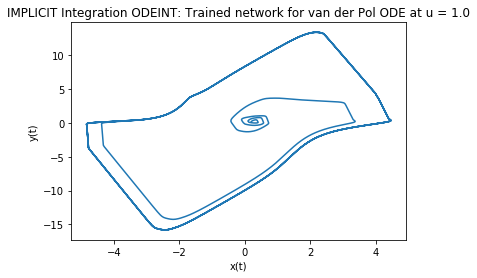

In [106]:
# %load viewPredict.py
import numpy as np
from pylab import *
from farbopt import PyPredFcn

from scipy.integrate import odeint

def predicted_rhs(x,t):
    return RHS.predict(x)
    
def van_der_pol_oscillator_deriv(x, t):
    nx0 = x[1]
    nx1 = -mu * (x[0] ** 2.0 - delta) * x[1] - omega * x[0]
    res = np.array([nx0, nx1])
    return res

ts = np.linspace(0.0, 50.0, nSamples)
# Setup the parametric plot
xlabel('x(t)') # set x-axis label
ylabel('y(t)') # set y-axis label
title('IMPLICIT Integration ODEINT: Trained network for van der Pol ODE at u = ' + str(mu)) # set plot title
RHS=PyPredFcn(b'param.dat')

xs = odeint(predicted_rhs, [0.2, 0.2], ts)
plt.plot(xs[:,0], xs[:,1])
plt.show() 